# Install required packages

In [4]:
!pip install python-docx pandas numpy matplotlib seaborn textblob wordcloud nltk scikit-learn gensim spacy python-louvain networkx
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.2 MB/s eta 0:00:00
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via 

# Import All Libraries

In [10]:
import os
import re
import docx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy


# Download NLTK Resources

In [11]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load spaCy Model (Optional but recommended)

In [12]:
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    print("spaCy model loaded successfully.")
except:
    nlp = None
    print("spaCy model NOT found. Using NLTK only.")

spaCy model loaded successfully.


# Read Word (.docx) Files

In [13]:
from google.colab import files
import docx
import pandas as pd
import os

def upload_and_read_docx():
    uploaded = files.upload()   # opens file browser
    data = []

    for fname, content in uploaded.items():
        doc = docx.Document(fname)
        text = "\n".join([p.text for p in doc.paragraphs])
        data.append([fname, text])

    df = pd.DataFrame(data, columns=["filename", "raw_text"])
    return df

df = upload_and_read_docx()
df.head()


Saving CEO Views on ESG, Sustainability Reporting.docx to CEO Views on ESG, Sustainability Reporting (1).docx


,filename,raw_text
0,"CEO Views on ESG, Sustainability Reporting (1)...",I am pleased to present the company’s comprehe...


# Basic Preprocessing

In [14]:
import re
def clean_sustainability_text(text):
    text = text.replace("\n", " ")
    text = re.sub(r"\b(annual report|sustainability report)\s*\d{4}\b", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s.]", " ", text)
    text = text.lower()
    text = re.sub(r"\b(?!20\d{2}\b)\d+\b", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
df["clean_text"] = df["raw_text"].apply(clean_sustainability_text)
df.head()

,filename,raw_text,clean_text
0,"CEO Views on ESG, Sustainability Reporting (1)...",I am pleased to present the company’s comprehe...,i am pleased to present the company s comprehe...


In [17]:
print(df["clean_text"])

0    i am pleased to present the company s comprehe...
Name: clean_text, dtype: object


# Tokenization + Stopwords + Lemmatization

In [18]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

df["tokens"] = df["clean_text"].apply(preprocess)
df["processed_text"] = df["tokens"].apply(lambda x: " ".join(x))


# Sentiment Analysis (TextBlob)

In [19]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df["polarity"], df["subjectivity"] = zip(*df["clean_text"].apply(get_sentiment))
df[["filename", "polarity", "subjectivity"]]


,filename,polarity,subjectivity
0,"CEO Views on ESG, Sustainability Reporting (1)...",0.160313,0.423101


# Word Frequency Analysis

In [20]:
from collections import Counter

all_words = [word for tokens in df["tokens"] for word in tokens]
word_freq = Counter(all_words).most_common(20)
word_freq


[('sustainability', 19),
 ('sustainable', 15),
 ('environmental', 14),
 ('company', 13),
 ('commitment', 11),
 ('economic', 10),
 ('pakistan', 9),
 ('report', 8),
 ('dedication', 8),
 ('business', 8),
 ('social', 8),
 ('impact', 8),
 ('challenge', 8),
 ('stakeholder', 7),
 ('energy', 7),
 ('strategy', 6),
 ('environment', 6),
 ('emission', 6),
 ('change', 6),
 ('water', 6)]

# N-Grams (Bigrams & Trigrams)

In [21]:
def top_ngrams(tokens_list, n=2, top_k=20):
    all_ngrams = []
    for tokens in tokens_list:
        all_ngrams += list(ngrams(tokens, n))
    return Counter(all_ngrams).most_common(top_k)

bigrams = top_ngrams(df["tokens"], n=2)
trigrams = top_ngrams(df["tokens"], n=3)

bigrams, trigrams


([(('sustainability', 'report'), 4),
  (('sustainable', 'development'), 4),
  (('sustainability', 'strategy'), 4),
  (('environmental', 'social'), 4),
  (('electric', 'vehicle'), 4),
  (('business', 'practice'), 3),
  (('sustainable', 'business'), 3),
  (('social', 'economic'), 3),
  (('economic', 'impact'), 3),
  (('environmental', 'stewardship'), 3),
  (('challenge', 'facing'), 3),
  (('climate', 'change'), 3),
  (('pleased', 'present'), 2),
  (('comprehensive', 'sustainability'), 2),
  (('stakeholder', 'value'), 2),
  (('long', 'term'), 2),
  (('carbon', 'emission'), 2),
  (('sustainable', 'growth'), 2),
  (('company', 'actively'), 2),
  (('remained', 'dedicated'), 2)],
 [(('environmental', 'social', 'economic'), 3),
  (('social', 'economic', 'impact'), 3),
  (('sustainable', 'business', 'practice'), 2),
  (('environmental', 'stewardship', 'social'), 2),
  (('stewardship', 'social', 'responsibility'), 2),
  (('social', 'responsibility', 'ethical'), 2),
  (('responsibility', 'ethical

# TF-IDF Keyword Extraction

In [22]:
tfidf = TfidfVectorizer(max_features=100)
X = tfidf.fit_transform(df["processed_text"])
keywords = tfidf.get_feature_names_out()

keywords[:20]


array(['actively', 'agriculture', 'also', 'automotive', 'broader',
       'business', 'carbon', 'challenge', 'change', 'cleaner', 'climate',
       'commitment', 'community', 'company', 'comprehensive', 'continued',
       'contribute', 'customer', 'dedicated', 'dedication'], dtype=object)

# Topic Modeling (LDA)

In [26]:
n_docs = df.shape[0]
print(f"Number of documents: {n_docs}")


Number of documents: 1


In [27]:
min_df = 1 if n_docs < 5 else max(2, int(0.1 * n_docs))
max_df = 0.95 if n_docs > 5 else 1.0
print(f"Using min_df={min_df}, max_df={max_df}")

Using min_df=1, max_df=1.0


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
count_data = count_vectorizer.fit_transform(df["processed_text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(count_data)

feature_names = count_vectorizer.get_feature_names_out()

topics = {}
for idx, topic in enumerate(lda.components_):
    # top 10 words per topic
    topics[idx] = [feature_names[i] for i in topic.argsort()[-10:]]

topics


{0: ['unique',
  'understand',
  'underscore',
  'aim',
  'agtl',
  'achieved',
  'yuasa',
  'accomplishment',
  'win',
  'workforce'],
 1: ['social',
  'report',
  'dedication',
  'pakistan',
  'economic',
  'commitment',
  'company',
  'environmental',
  'sustainable',
  'sustainability'],
 2: ['unique',
  'understand',
  'underscore',
  'aim',
  'agtl',
  'achieved',
  'yuasa',
  'accomplishment',
  'win',
  'workforce'],
 3: ['unique',
  'understand',
  'underscore',
  'aim',
  'agtl',
  'achieved',
  'yuasa',
  'accomplishment',
  'win',
  'workforce'],
 4: ['unique',
  'understand',
  'underscore',
  'aim',
  'agtl',
  'achieved',
  'yuasa',
  'accomplishment',
  'win',
  'workforce']}

# Visualization (Word Frequency Bar Chart)

/tmp/ipython-input-923218513.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


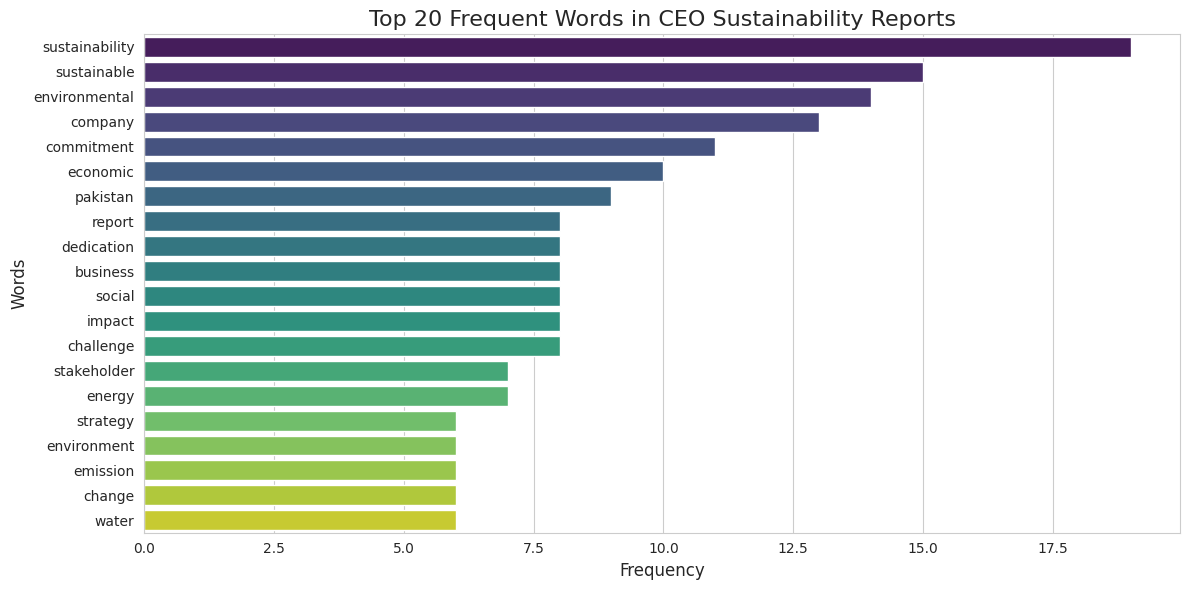

In [29]:
from collections import Counter
all_words = [word for tokens_list in df['tokens'] for word in tokens_list]
word_freq = Counter(all_words).most_common(20)  # top 20 words
words, counts = zip(*word_freq)
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Frequent Words in CEO Sustainability Reports", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Words", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Word Cloud

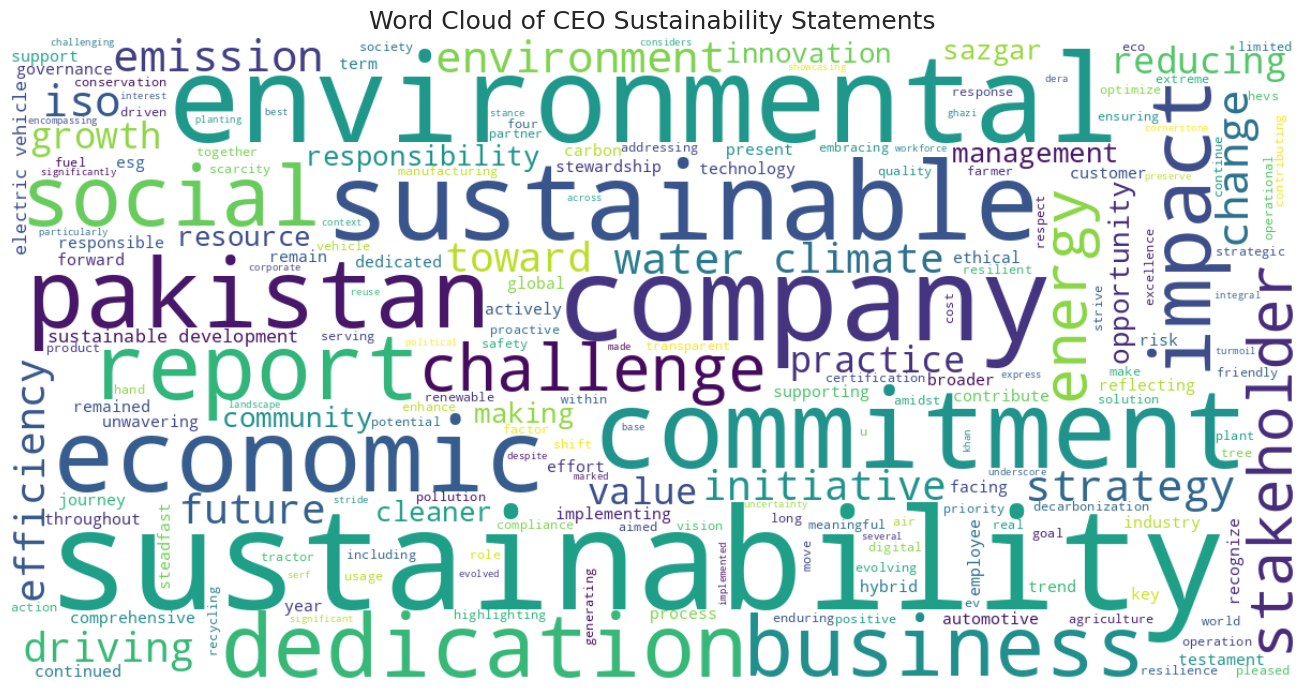

In [30]:
from wordcloud import WordCloud
full_text = " ".join(df["processed_text"])
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis",
    max_words=200,
    contour_width=3,
    contour_color='steelblue'
).generate(full_text)
plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of CEO Sustainability Statements", fontsize=18)
plt.tight_layout()
plt.show()

In [38]:
wc.to_file("wordcloud.png")
plt.show()